# Datathon - March 2021

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model      import LinearRegression
from sklearn.linear_model      import Lasso
from sklearn.model_selection   import train_test_split
from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import FunctionTransformer
from sklearn.preprocessing     import OneHotEncoder
from sklearn.preprocessing     import OrdinalEncoder
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import StandardScaler
from sklearn.pipeline          import Pipeline
from sklearn.decomposition     import PCA
from sklearn.tree              import DecisionTreeRegressor
from sklearn.tree              import DecisionTreeClassifier
from sklearn.neighbors         import KNeighborsRegressor
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.model_selection   import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.ensemble          import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics           import mean_squared_error
from sklearn.linear_model      import RidgeCV
from sklearn.svm               import SVR

#### 1) Import dataset for training our model

In [2]:
cookies = pd.read_csv('../data/cookies.csv')

#### 2.1) Drop columns with low variance

In [3]:
cookies.drop(columns=["aesthetic appeal", "diameter"], inplace=True)

#### 2.2) Drop row with pH > 14

In [4]:
cookies.drop(16, inplace=True)
cookies.reset_index(inplace=True)

#### 2.3) Split 'mixins' column in ingredients

In [5]:
cookies['chocolate'] = 0
cookies['raisins'] = 0
cookies['oats'] = 0
cookies['nuts'] = 0
cookies['peanut butter'] = 0

mixins = ['chocolate', 'raisins', 'oats', 'nuts', 'peanut butter']
cookies['mixins'].fillna(value = ' ', axis=0, inplace=True)
for mix in mixins:
    for i in range(len(cookies)):
        if mix in [x.strip() for x in cookies.loc[i, 'mixins'].split(',')]:
            cookies.loc[i, mix] = 1
            
cookies.drop(columns=["mixins"], inplace=True)

#### 2.4) Split data between training set and test set

In [6]:
X = cookies.drop(columns="quality")
y = cookies["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=13)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=8)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, test_size=0.2, random_state=9)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y, test_size=0.2, random_state=2)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X, y, test_size=0.2, random_state=27)
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X, y, test_size=0.2, random_state=171)
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X, y, test_size=0.2, random_state=500)
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(X, y, test_size=0.2, random_state=17)

#### 2.5) Fill numeric columns with the median for all the None values

In [7]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(exclude=["int64", "float64"]).columns

In [8]:
def fill_numeric_nulls(df):
    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(df)
    return X

numeric_nulls_imputer = FunctionTransformer(fill_numeric_nulls)

#### 2.6) One Hot Encoding for 'butter type' column

In [9]:
categ_encode_pipeline = ColumnTransformer([
    ("onehot_enc", OneHotEncoder(handle_unknown="ignore"), ['butter type'])
])

#### 2.7) Create the intermediate pipeline joining numeric column transformations and categorical transformations.

In [10]:
intermediate_pipeline = ColumnTransformer([
    ("num_nulls_imp", numeric_nulls_imputer, num_cols),
    ("cat_fill_pipe", categ_encode_pipeline, cat_cols)
])

#### 2.8) Creating the Decision Tree Regressor

In [11]:
feature_selector_dtree = SelectFromModel(DecisionTreeRegressor(), max_features=7)

#### 3.1) Creating the pipeline for Linear Regression Model

In [12]:
pipeline_reg = Pipeline([
    ("intermediate_pipe", intermediate_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("reg", LinearRegression())
])

#### 3.2) Creating the pipeline for Lasso Regression Model

0.05  -->  0.5755507612591264
0.1  -->  0.6143859220317917
0.15000000000000002  -->  0.6475451299225103
0.2  -->  0.689857879705189
0.25  -->  0.7390284023711559
0.3  -->  0.7978249218638157
0.35000000000000003  -->  0.8664965263486106
0.4  -->  0.9366527252620885
0.45  -->  0.9832033267471109
0.5  -->  1.0349463165495247
0.55  -->  1.0918816946693353
0.6000000000000001  -->  1.1540094611065395
0.6500000000000001  -->  1.221329615861143
0.7000000000000001  -->  1.2938421589331397
0.7500000000000001  -->  1.37154709032253
0.8  -->  1.4544444100293201
0.8500000000000001  -->  1.542534118053509
0.9000000000000001  -->  1.6358162143950885


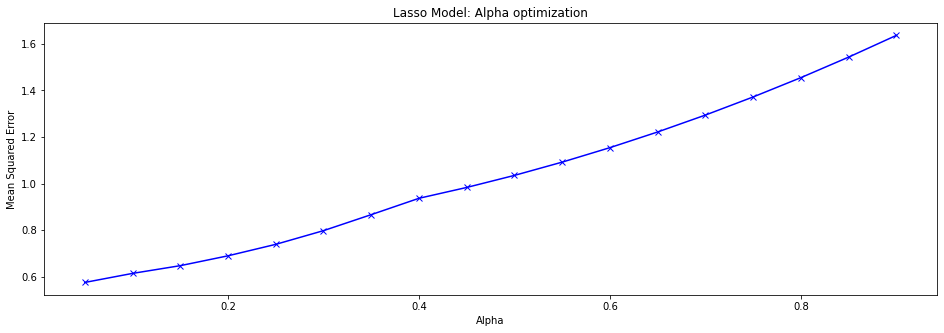

In [13]:
K = np.arange(0.05, 0.95, 0.05)
rmse = []
for k in K:
    pipeline_lasso = Pipeline([
        ("intermediate_pipe", intermediate_pipeline),
        ("standard_scal", StandardScaler()),
        #("feature_select", feature_selector_dtree),
        #("pca", PCA(n_components=0.95)),
        ("lasso", Lasso(alpha=k))
    ])
    pipeline_lasso.fit(X_train, y_train)
    y_pred = pipeline_lasso.predict(X_test)
    rmse.append(mean_squared_error(y_test, y_pred))
    print(str(k), " --> ", str(mean_squared_error(y_test, y_pred)))
    
# plot
plt.figure(figsize=(16,5))
plt.plot(K, rmse, 'bx-')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Model: Alpha optimization')
plt.savefig('../figures/lasso_model.png', transparent=True)

In [14]:
pipeline_lasso = Pipeline([
    ("intermediate_pipe", intermediate_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("lasso", Lasso(alpha=0.05))
])

#### 3.3) Creating the pipeline for SVR Regression Model

0.05  -->  0.5111610442697389
0.1  -->  0.5083679321798164
0.15000000000000002  -->  0.5048087206927588
0.2  -->  0.5033542410998884
0.25  -->  0.5030275734292018
0.3  -->  0.5037865664291886
0.35000000000000003  -->  0.5038319859455719
0.4  -->  0.5057053686542997
0.45  -->  0.5090865840110107
0.5  -->  0.5115561181976364
0.55  -->  0.5111813828625436
0.6000000000000001  -->  0.5117436803083794
0.6500000000000001  -->  0.5134517581568433
0.7000000000000001  -->  0.5150954112387902
0.7500000000000001  -->  0.5168613408637294
0.8  -->  0.5164170350482495
0.8500000000000001  -->  0.5176580670190705
0.9000000000000001  -->  0.5223552296035668


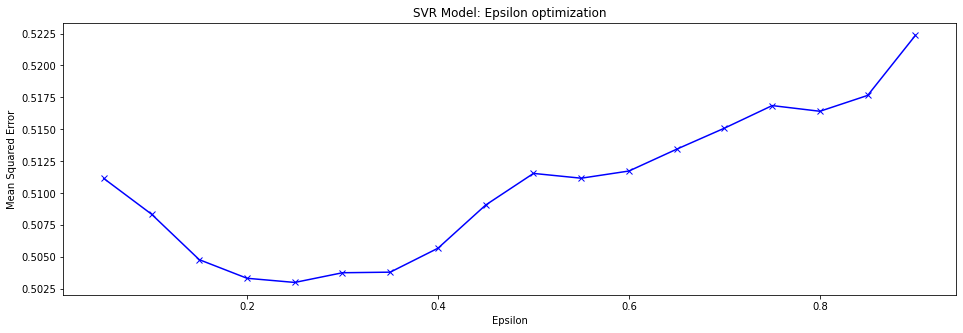

In [15]:
K = np.arange(0.05, 0.95, 0.05)
rmse = []
for k in K:
    pipeline_svr = Pipeline([
        ("intermediate_pipe", intermediate_pipeline),
        ("standard_scal", StandardScaler()),
        #("feature_select", feature_selector_dtree),
        #("pca", PCA(n_components=0.95)),
        ("svr", SVR(C=1, epsilon=k))
    ])
    pipeline_svr.fit(X_train, y_train)
    y_pred = pipeline_svr.predict(X_test)
    rmse.append(mean_squared_error(y_test, y_pred))
    print(str(k), " --> ", str(mean_squared_error(y_test, y_pred)))
    
# plot
# plot
plt.figure(figsize=(16,5))
plt.plot(K, rmse, 'bx-')
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.title('SVR Model: Epsilon optimization')
plt.savefig('../figures/svr_model.png', transparent=True)

In [16]:
pipeline_svr = Pipeline([
    ("intermediate_pipe", intermediate_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("svr", SVR(C=1.0, epsilon=0.3))
])

#### 3.4) Creating the pipeline for KNeighbors Regression Model

1  -->  0.739423076923077
2  -->  0.6035481826160656
3  -->  0.5728374880605027
4  -->  0.5423817327775282
5  -->  0.5226645090021361
6  -->  0.5215077884504612
7  -->  0.5143226685359651
8  -->  0.513256657255059
9  -->  0.5069629909260674
10  -->  0.5064319782609715
11  -->  0.5051486863306385
12  -->  0.5123205636936483
13  -->  0.5113296585001653
14  -->  0.51164530403513
15  -->  0.510059766287407
16  -->  0.5105299292163218
17  -->  0.5107592097589986
18  -->  0.5139153047390358
19  -->  0.514479174455782
20  -->  0.5146052987966743
21  -->  0.5169452400056793
22  -->  0.5180241342829245
23  -->  0.5182540438448082
24  -->  0.5195864024175537
25  -->  0.5207030163882891
26  -->  0.5214199106190965
27  -->  0.5212382179511336
28  -->  0.522588919300245
29  -->  0.5238475013983447
30  -->  0.5249814006263702
31  -->  0.525661743110434
32  -->  0.5263291952468386
33  -->  0.526764469991036
34  -->  0.5256730217538197
35  -->  0.5278350049572237
36  -->  0.5281563288580658
37  -->  0

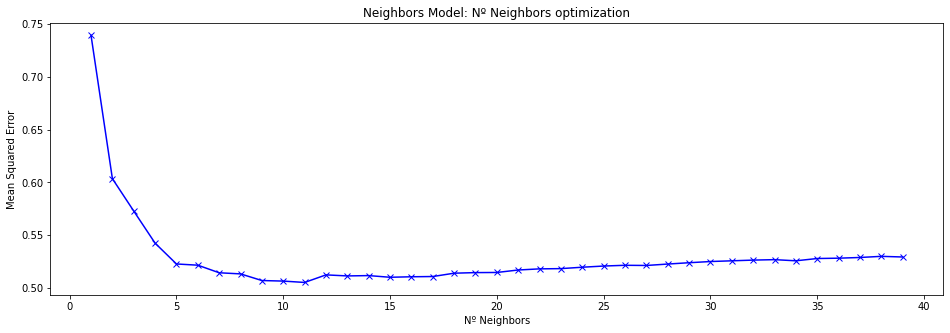

In [17]:
K = range(1, 40)
rmse = []
for k in K:
    pipeline_neigh = Pipeline([
        ("intermediate_pipe", intermediate_pipeline),
        ("standard_scal", StandardScaler()),
        #("feature_select", feature_selector_dtree),
        #("pca", PCA(n_components=0.95)),
        ("neigh", KNeighborsRegressor(n_neighbors=k, weights = 'distance', p=1))
    ])
    pipeline_neigh.fit(X_train, y_train)
    y_pred = pipeline_neigh.predict(X_test)
    rmse.append(mean_squared_error(y_test, y_pred))
    print(str(k), " --> ", str(mean_squared_error(y_test, y_pred)))
    
# plot
plt.figure(figsize=(16,5))
plt.plot(K, rmse, 'bx-')
plt.xlabel('Nº Neighbors')
plt.ylabel('Mean Squared Error')
plt.title('Neighbors Model: Nº Neighbors optimization')
plt.savefig('../figures/neigh_model.png', transparent=True)

In [18]:
pipeline_neigh = Pipeline([
    ("intermediate_pipe", intermediate_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("neigh", KNeighborsRegressor(n_neighbors=9, weights = 'distance', p=1))
])

#### 3.5) Creating the pipeline for Decision Tree Regression Model

In [19]:
pipeline_dec_tree = Pipeline([
    ("intermediate_pipe", intermediate_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("dec_tree", DecisionTreeRegressor(random_state=0))
])

#### 3.6) Creating the pipeline for Random Forest Regression Model

10  -->  0.4874807692307693
30  -->  0.47064423076923073
50  -->  0.45667384615384615
70  -->  0.4510963500784929
90  -->  0.4513833095916429
110  -->  0.44740845518118244
130  -->  0.44718070095584894
150  -->  0.44711876068376066
170  -->  0.4471003792919883
190  -->  0.4448221819731515
210  -->  0.44464113465899185
230  -->  0.44492514904754976
250  -->  0.4451113538461538
270  -->  0.44482362561992195
290  -->  0.44483504070246044


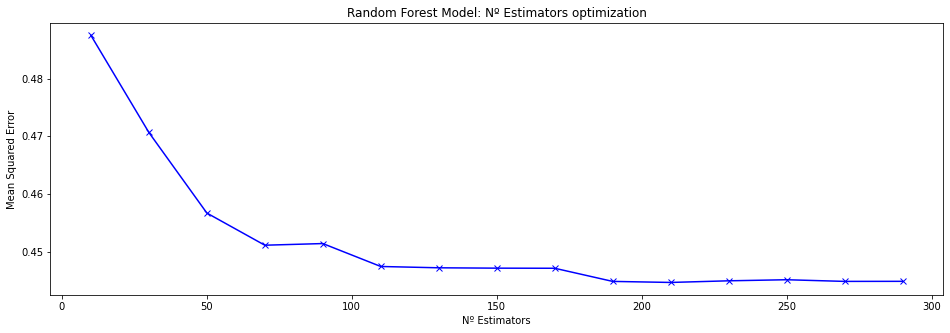

In [20]:
K = np.arange(10, 300, 20)
rmse = []
for k in K:
    pipeline_rfr = Pipeline([
        ("intermediate_pipe", intermediate_pipeline),
        ("standard_scal", StandardScaler()),
        #("feature_select", feature_selector_dtree),
        #("pca", PCA(n_components=k)),
        ("rfr", RandomForestRegressor(n_estimators=k, random_state=0))
    ])
    pipeline_rfr.fit(X_train, y_train)
    y_pred = pipeline_rfr.predict(X_test)
    rmse.append(mean_squared_error(y_test, y_pred))
    print(str(k), " --> ", str(mean_squared_error(y_test, y_pred)))
    
# plot
plt.figure(figsize=(16,5))
plt.plot(K, rmse, 'bx-')
plt.xlabel('Nº Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Random Forest Model: Nº Estimators optimization')
plt.savefig('../figures/rfr_model.png', transparent=True)

In [21]:
pipeline_rfr = Pipeline([
    ("intermediate_pipe", intermediate_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("rfr", RandomForestRegressor(n_estimators=170, random_state=0))
])

#### 3.7) Creating the pipeline for ADA Boost Regression Model

In [22]:
pipeline_ada = Pipeline([
    ("intermediate_pipe", intermediate_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("ada", AdaBoostRegressor(n_estimators=100, random_state=0))
])

#### 3.8) Creating the pipeline for Gradient Boost Regression Model

10  -->  0.7272256714279773
20  -->  0.568471283823085
30  -->  0.5299401281572054
40  -->  0.5131093019643753
50  -->  0.5046897957991403
60  -->  0.49686777628097023
70  -->  0.49124718436294257
80  -->  0.4902181724276156
90  -->  0.4881943855578819
100  -->  0.4863851221734299
110  -->  0.4850016885909475
120  -->  0.4837552304749194
130  -->  0.4822487234027443
140  -->  0.48137443192378804
150  -->  0.4812464629071987
160  -->  0.48048047414353445
170  -->  0.48017978267291245
180  -->  0.4800969596410255
190  -->  0.47900723451057253
200  -->  0.47795086144590515
210  -->  0.4761452826433429
220  -->  0.4760255371043103
230  -->  0.47511626404613305
240  -->  0.47495071424542795
250  -->  0.47384354567012166
260  -->  0.4728473387591823
270  -->  0.47283752825679926
280  -->  0.47251870726777556
290  -->  0.47178438678878165


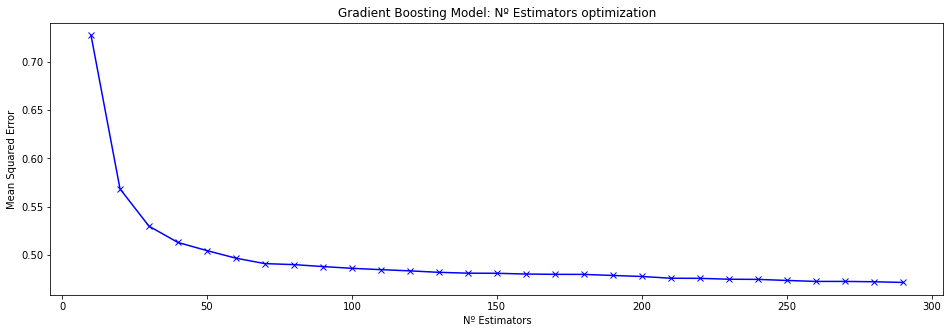

In [23]:
K = range(10, 300, 10)
rmse = []
for k in K:
    pipeline_grad = Pipeline([
        ("intermediate_pipe", intermediate_pipeline),
        ("standard_scal", StandardScaler()),
        #("feature_select", feature_selector_dtree),
        #("pca", PCA(n_components=0.99)),
        ("grad", GradientBoostingRegressor(n_estimators=k, random_state=0))
    ])
    pipeline_grad.fit(X_train, y_train)
    y_pred = pipeline_grad.predict(X_test)
    rmse.append(mean_squared_error(y_test, y_pred))
    print(str(k), " --> ", str(mean_squared_error(y_test, y_pred)))
    
# plot
plt.figure(figsize=(16,5))
plt.plot(K, rmse, 'bx-')
plt.xlabel('Nº Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Gradient Boosting Model: Nº Estimators optimization')
plt.savefig('../figures/grad_model.png', transparent=True)

In [24]:
pipeline_grad = Pipeline([
    ("intermediate_pipe", intermediate_pipeline),
    ("standard_scal", StandardScaler()),
    #("feature_select", feature_selector_dtree),
    #("pca", PCA(n_components=0.95)),
    ("grad", GradientBoostingRegressor(n_estimators=230, random_state=0))
])

#### 3.9) Creating the Stacking Regressor

In [25]:
estimators = [('neigh', pipeline_neigh),
              #('svr', pipeline_svr),
              ('rfr', pipeline_rfr),
              ('grad', pipeline_grad)
             ]

In [26]:
stacking_regressor = StackingRegressor(estimators=estimators)

#### 4.1) Try all the pipelines in order to choose the better model

In [27]:
pipeline_reg.fit(X_train, y_train)
pipeline_lasso.fit(X_train, y_train)
pipeline_svr.fit(X_train, y_train)
pipeline_neigh.fit(X_train, y_train)
pipeline_dec_tree.fit(X_train, y_train)
pipeline_rfr.fit(X_train, y_train)
pipeline_ada.fit(X_train, y_train)
pipeline_grad.fit(X_train, y_train)
stacking_regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('neigh',
                               Pipeline(steps=[('intermediate_pipe',
                                                ColumnTransformer(transformers=[('num_nulls_imp',
                                                                                 FunctionTransformer(func=<function fill_numeric_nulls at 0x1465085e0>),
                                                                                 Index(['index', 'sugar to flour ratio', 'sugar index', 'bake temp',
       'chill time', 'calories', 'density', 'pH', 'grams baking soda',
       'bake time', 'weight', 'crunch factor', 'chocol...
       'bake time', 'weight', 'crunch factor', 'chocolate', 'raisins', 'oats',
       'nuts', 'peanut butter'],
      dtype='object')),
                                                                                ('cat_fill_pipe',
                                                                                 ColumnTransformer(transformers=[('onehot_enc',


#### 4.2) Create predictions for each pipeline

In [28]:
y_pred_reg      = pipeline_reg.predict(X_test)
y_pred_lasso    = pipeline_lasso.predict(X_test)
y_pred_svr      = pipeline_svr.predict(X_test)
y_pred_neigh    = pipeline_neigh.predict(X_test)
y_pred_dec_tree = pipeline_dec_tree.predict(X_test)
y_pred_rfr      = pipeline_rfr.predict(X_test)
y_pred_ada      = pipeline_ada.predict(X_test)
y_pred_grad     = pipeline_grad.predict(X_test)
y_pred_stack    = stacking_regressor.predict(X_test)

#### 4.3) Calculate the mean squared error for each predictions

In [29]:
print('reg     ', mean_squared_error(y_test, y_pred_reg))
print('lasso   ', mean_squared_error(y_test, y_pred_lasso))
print('svr     ', mean_squared_error(y_test, y_pred_svr))
print('neigh   ', mean_squared_error(y_test, y_pred_neigh))
print('dec_tree', mean_squared_error(y_test, y_pred_dec_tree))
print('rfr     ', mean_squared_error(y_test, y_pred_rfr))
print('ada     ', mean_squared_error(y_test, y_pred_ada))
print('grad    ', mean_squared_error(y_test, y_pred_grad))
print('stack   ', mean_squared_error(y_test, y_pred_stack))

reg      0.5474463145568709
lasso    0.5755507612591264
svr      0.5037865664291886
neigh    0.5069629909260674
dec_tree 0.7644230769230769
rfr      0.4471003792919883
ada      0.5639294154229482
grad     0.47511626404613305
stack    0.4430850425458047


#### 5.1) Fitting our best model with the full data

In [30]:
stacking_regressor.fit(X, y)

StackingRegressor(estimators=[('neigh',
                               Pipeline(steps=[('intermediate_pipe',
                                                ColumnTransformer(transformers=[('num_nulls_imp',
                                                                                 FunctionTransformer(func=<function fill_numeric_nulls at 0x1465085e0>),
                                                                                 Index(['index', 'sugar to flour ratio', 'sugar index', 'bake temp',
       'chill time', 'calories', 'density', 'pH', 'grams baking soda',
       'bake time', 'weight', 'crunch factor', 'chocol...
       'bake time', 'weight', 'crunch factor', 'chocolate', 'raisins', 'oats',
       'nuts', 'peanut butter'],
      dtype='object')),
                                                                                ('cat_fill_pipe',
                                                                                 ColumnTransformer(transformers=[('onehot_enc',


#### 5.2) Importing the validation set + cleaning the data

In [31]:
cookies_val = pd.read_csv('../data/cookies_validate.csv')

In [32]:
cookies_val.drop(columns=["aesthetic appeal", "diameter"], inplace=True)

In [33]:
cookies_val['chocolate'] = 0
cookies_val['raisins'] = 0
cookies_val['oats'] = 0
cookies_val['nuts'] = 0
cookies_val['peanut butter'] = 0

mixins = ['chocolate', 'raisins', 'oats', 'nuts', 'peanut butter']
cookies_val['mixins'].fillna(value = ' ', axis=0, inplace=True)
for mix in mixins:
    for i in range(len(cookies_val)):
        if mix in [x.strip() for x in cookies_val.loc[i, 'mixins'].split(',')]:
            cookies_val.loc[i, mix] = 1
            
cookies_val.drop(columns=["mixins"], inplace=True)

In [34]:
cookies_val.drop(columns= 'id', inplace=True)
cookies_val.reset_index(inplace=True)

In [35]:
X_val = cookies_val.drop(columns="quality")
y_val = cookies_val["quality"]

In [36]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 779 non-null    int64  
 1   sugar to flour ratio  779 non-null    float64
 2   sugar index           779 non-null    float64
 3   bake temp             779 non-null    float64
 4   chill time            779 non-null    float64
 5   calories              779 non-null    float64
 6   density               779 non-null    float64
 7   pH                    779 non-null    float64
 8   grams baking soda     779 non-null    float64
 9   bake time             779 non-null    float64
 10  butter type           779 non-null    object 
 11  weight                779 non-null    float64
 12  crunch factor         779 non-null    float64
 13  chocolate             779 non-null    int64  
 14  raisins               779 non-null    int64  
 15  oats                  7

#### 6) Final prediction

In [37]:
y_final_pred = stacking_regressor.predict(X_val)

In [38]:
y_final_pred

array([7.40841087, 8.29305646, 7.71519745, 8.14552621, 7.5471351 ,
       7.42810347, 7.99990815, 7.43039624, 7.49580062, 7.85190657,
       7.75922586, 8.0427392 , 7.35264926, 8.02312122, 8.32895687,
       7.59721183, 8.23914016, 7.62051516, 8.08970762, 8.33708832,
       7.85794696, 8.25810841, 8.47032503, 7.66562313, 7.23777081,
       6.87947877, 7.46003396, 7.38069279, 7.08271112, 7.50247305,
       7.95831124, 7.99346649, 7.3847788 , 8.02848289, 8.22608659,
       8.45105819, 9.29202874, 8.26053953, 6.75252387, 7.5884409 ,
       8.13456463, 7.21135092, 7.98756662, 7.46779125, 7.34129214,
       7.62848934, 7.34909856, 8.14978339, 7.45075152, 7.74687675,
       7.0787044 , 7.48031876, 7.72941409, 7.80645299, 7.72694385,
       7.8848951 , 7.47038581, 7.82031303, 8.24225204, 8.80472598,
       7.61620643, 7.75400882, 7.07862435, 8.28098483, 8.26882853,
       7.84841805, 7.43055653, 7.56786699, 7.5997035 , 8.24722159,
       7.98306769, 8.44935061, 6.80732475, 7.00021751, 8.14988

### Home made cross-validation algorithm:

In [39]:
stacking_regressor.fit(X_train_1, y_train_1)
y_pred_stack_1 = stacking_regressor.predict(X_test_1)
mse_1 = mean_squared_error(y_test_1, y_pred_stack_1)
print('stack 1:', mse_1)

stacking_regressor.fit(X_train_2, y_train_2)
y_pred_stack_2 = stacking_regressor.predict(X_test_2)
mse_2 = mean_squared_error(y_test_2, y_pred_stack_2)
print('stack 2:', mse_2)

stacking_regressor.fit(X_train_3, y_train_3)
y_pred_stack_3 = stacking_regressor.predict(X_test_3)
mse_3 = mean_squared_error(y_test_3, y_pred_stack_3)
print('stack 3:', mse_3)

stacking_regressor.fit(X_train_4, y_train_4)
y_pred_stack_4 = stacking_regressor.predict(X_test_4)
mse_4 = mean_squared_error(y_test_4, y_pred_stack_4)
print('stack 4:', mse_4)

stacking_regressor.fit(X_train_5, y_train_5)
y_pred_stack_5 = stacking_regressor.predict(X_test_5)
mse_5 = mean_squared_error(y_test_5, y_pred_stack_5)
print('stack 5:', mse_5)

stacking_regressor.fit(X_train_6, y_train_6)
y_pred_stack_6 = stacking_regressor.predict(X_test_6)
mse_6 = mean_squared_error(y_test_6, y_pred_stack_6)
print('stack 6:', mse_6)

stacking_regressor.fit(X_train_7, y_train_7)
y_pred_stack_7 = stacking_regressor.predict(X_test_7)
mse_7 = mean_squared_error(y_test_7, y_pred_stack_7)
print('stack 7:', mse_7)

stacking_regressor.fit(X_train_8, y_train_8)
y_pred_stack_8 = stacking_regressor.predict(X_test_8)
mse_8 = mean_squared_error(y_test_8, y_pred_stack_8)
print('stack 8:', mse_8)

print('mean: ', np.array([mse_1, mse_2, mse_3, mse_4, mse_5, mse_6, mse_7, mse_8]).mean())

stack 1: 0.43686795537642753
stack 2: 0.4490261976954934
stack 3: 0.37197515131324693
stack 4: 0.38298023820422106
stack 5: 0.4115305818209919
stack 6: 0.3997460307410421
stack 7: 0.4157686793421795
stack 8: 0.44150978420778425
mean:  0.4136755773376733


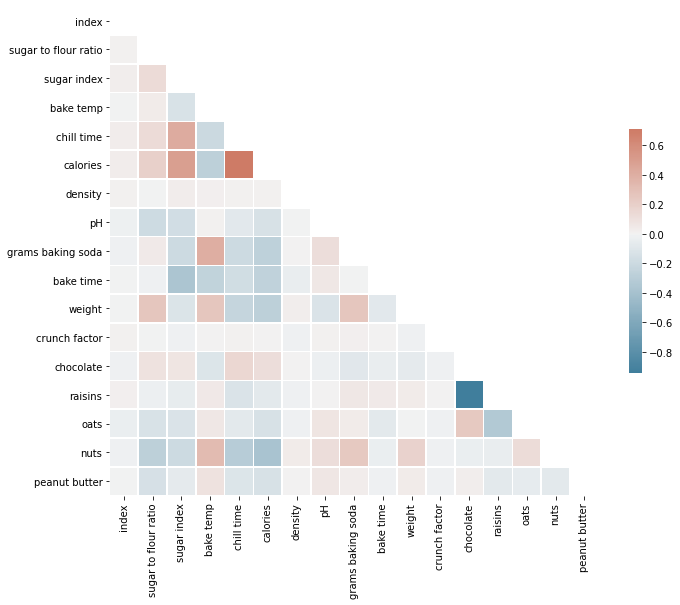

In [40]:
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig14, ax14 = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig('../figures/corr_matrix.png', transparent=True)